# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
df['flight_hour'].unique()

array([ 7,  3, 17,  4, 15, 20,  6, 14, 12,  2, 19, 10,  8, 23,  9, 13, 11,
        0,  1,  5, 16, 18, 22, 21])

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df["booking_complete"].value_counts(normalize=True)*100

0    85.044
1    14.956
Name: booking_complete, dtype: float64

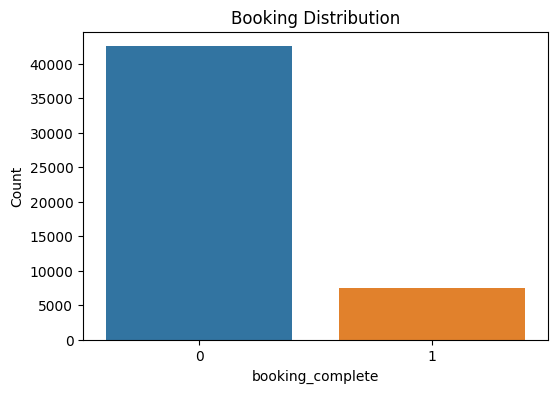

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='booking_complete', data=df)
plt.xlabel('booking_complete')
plt.ylabel('Count')
plt.title('Booking Distribution')
plt.show()

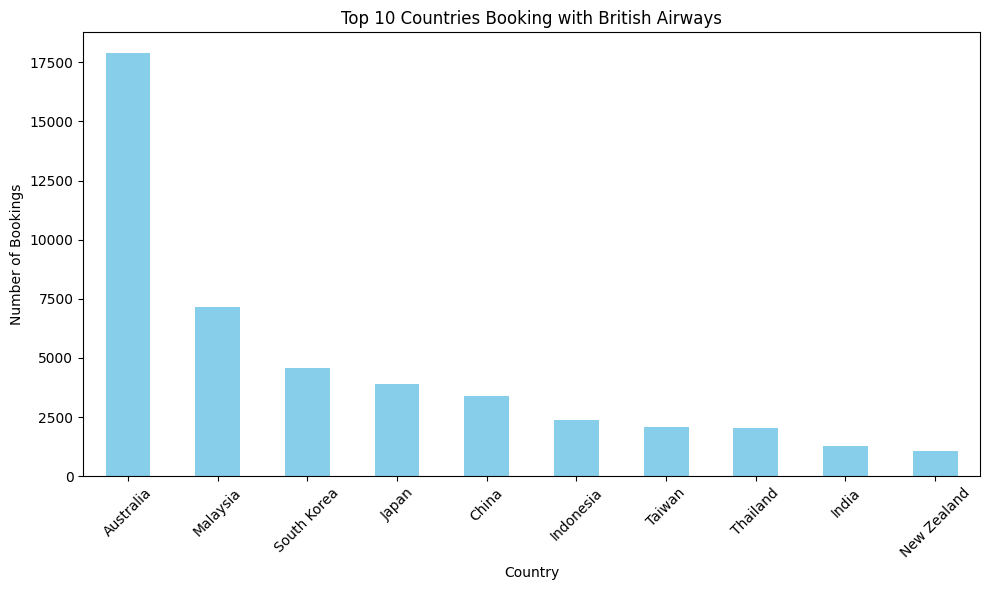

In [10]:
# Count the occurrences of each country and sort in descending order
country_counts = df['booking_origin'].value_counts()

# Select the top 10 countries
top_countries = country_counts.head(10)

# Create a bar plot for the top countries
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries Booking with British Airways')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

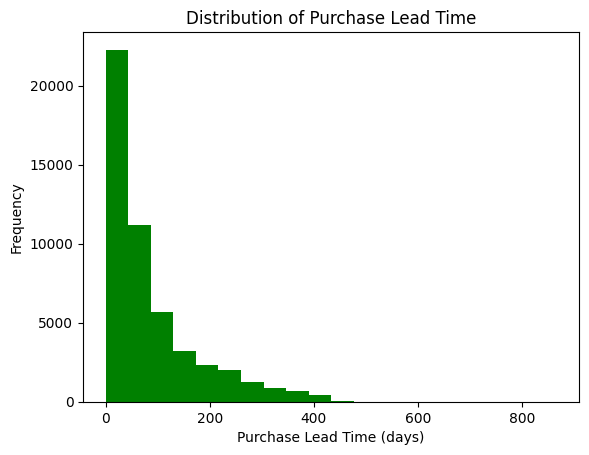

In [11]:
# Create a histogram for 'purchase_lead'
plt.hist(df['purchase_lead'], bins=20, color='green')
plt.title('Distribution of Purchase Lead Time')
plt.xlabel('Purchase Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

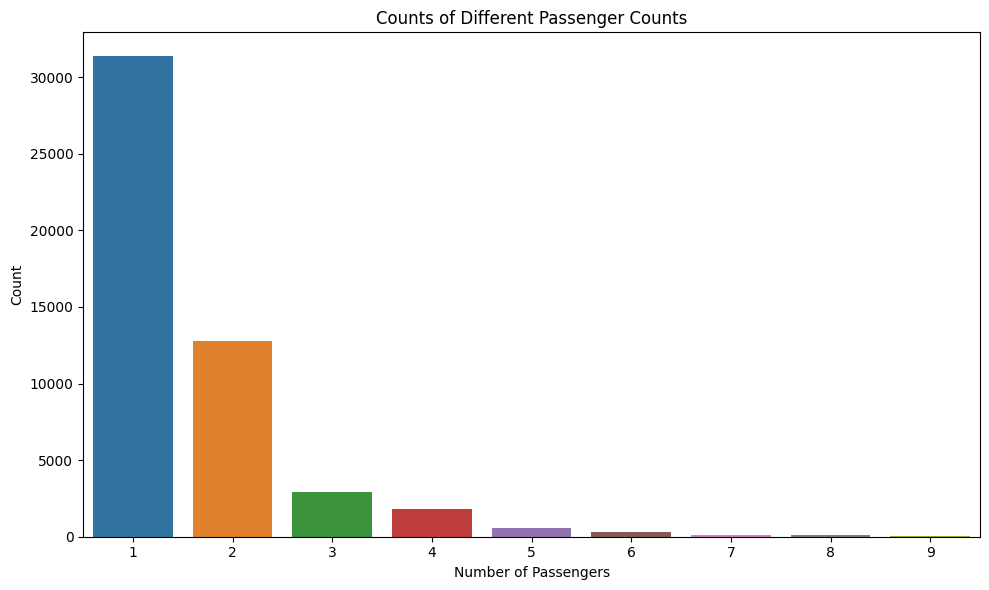

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='num_passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.title('Counts of Different Passenger Counts')
plt.tight_layout()
plt.show()

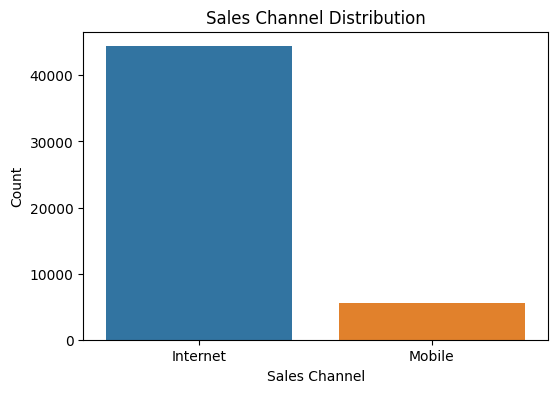

In [13]:
# Create a bar plot for 'sales_channel'
plt.figure(figsize=(6, 4))
sns.countplot(x='sales_channel', data=df)
plt.xlabel('Sales Channel')
plt.ylabel('Count')
plt.title('Sales Channel Distribution')
plt.show()

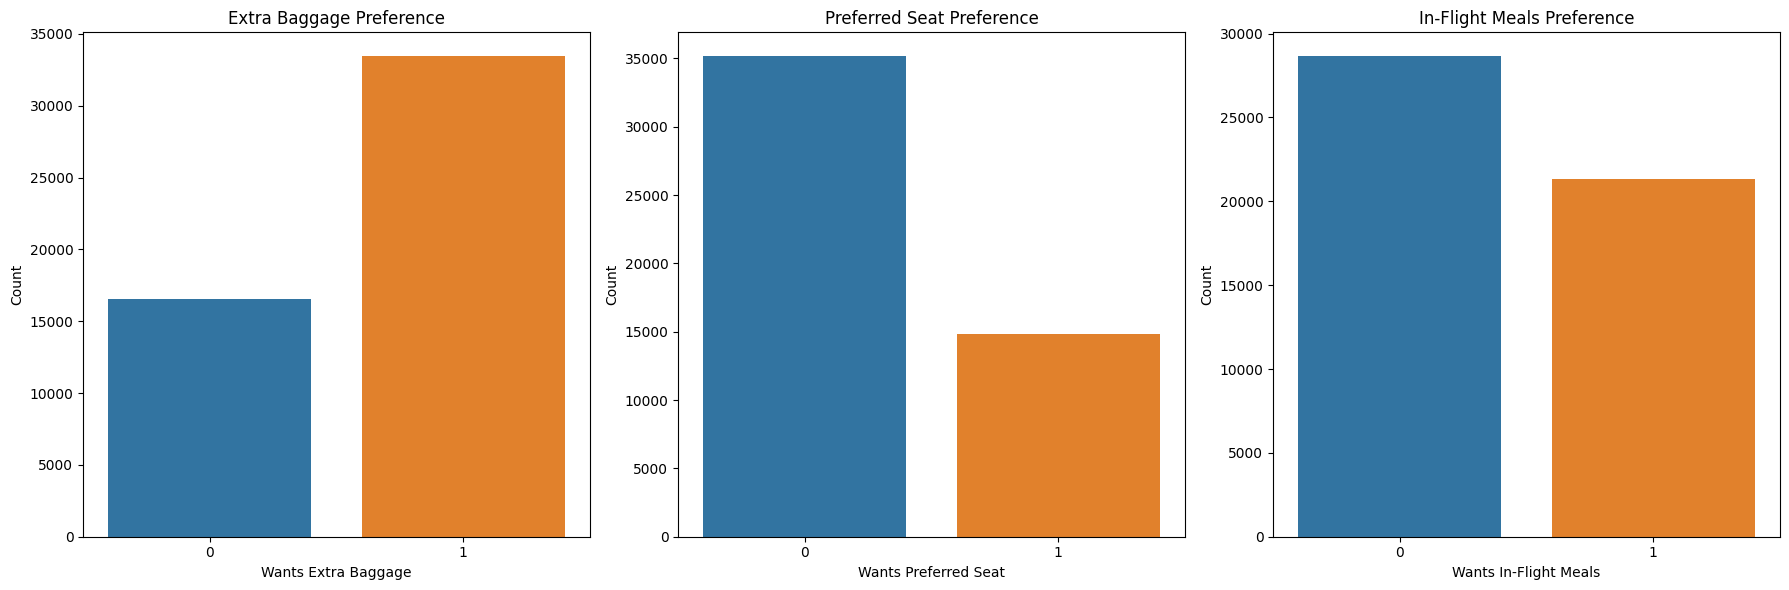

In [14]:
# Set up the subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot for 'wants_extra_baggage'
sns.countplot(data=df, x='wants_extra_baggage', ax=axes[0])
axes[0].set_title('Extra Baggage Preference')
axes[0].set_xlabel('Wants Extra Baggage')
axes[0].set_ylabel('Count')

# Bar plot for 'wants_preferred_seat'
sns.countplot(data=df, x='wants_preferred_seat', ax=axes[1])
axes[1].set_title('Preferred Seat Preference')
axes[1].set_xlabel('Wants Preferred Seat')
axes[1].set_ylabel('Count')

# Bar plot for 'wants_in_flight_meals'
sns.countplot(data=df, x='wants_in_flight_meals', ax=axes[2])
axes[2].set_title('In-Flight Meals Preference')
axes[2].set_xlabel('Wants In-Flight Meals')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

/var/folders/zp/hlds8m997jl7vy4l10k7qd2w0000gn/T/ipykernel_1042/3928287960.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


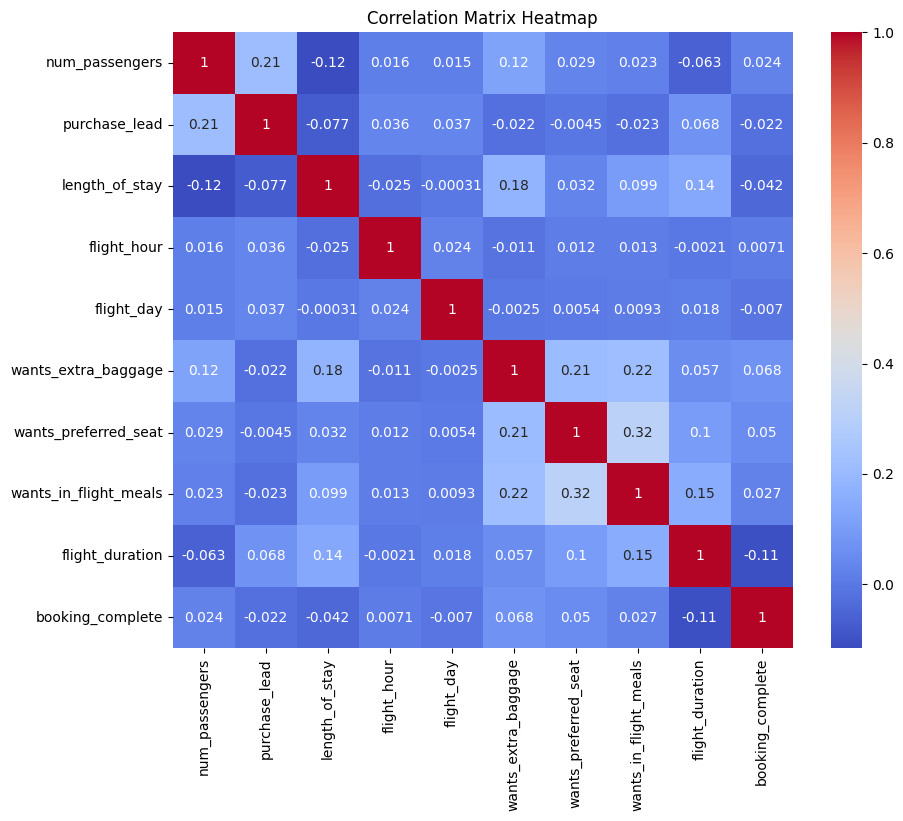

In [15]:
# Create a correlation matrix heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

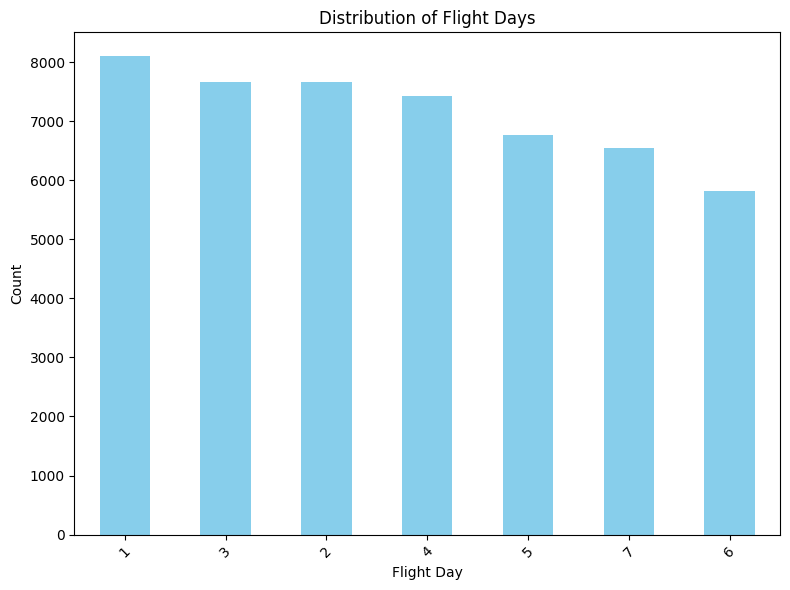

In [16]:
# Create a bar plot for 'flight_day'
plt.figure(figsize=(8, 6))
df['flight_day'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Flight Days')
plt.xlabel('Flight Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


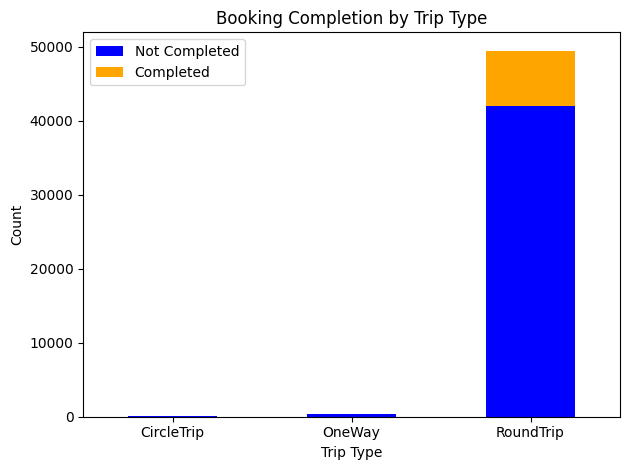

In [17]:
# Create a stacked bar plot for booking completion by 'trip_type'
booking_completion_by_trip = df.groupby(['trip_type', 'booking_complete']).size().unstack()
booking_completion_by_trip.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title('Booking Completion by Trip Type')
plt.xlabel('Trip Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['Not Completed', 'Completed'])
plt.tight_layout()
plt.show()


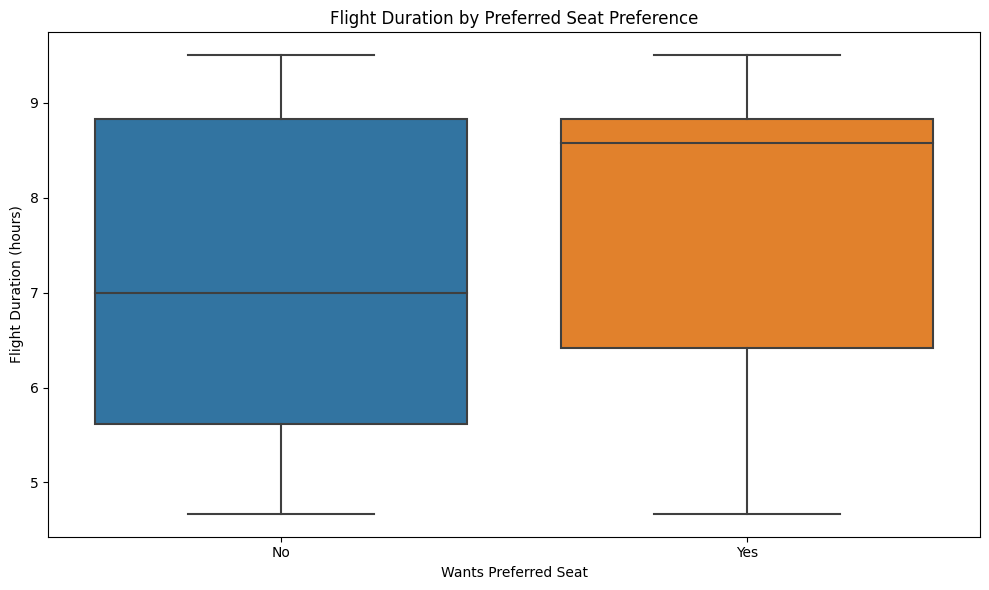

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='wants_preferred_seat', y='flight_duration')
plt.xlabel('Wants Preferred Seat')
plt.ylabel('Flight Duration (hours)')
plt.title('Flight Duration by Preferred Seat Preference')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

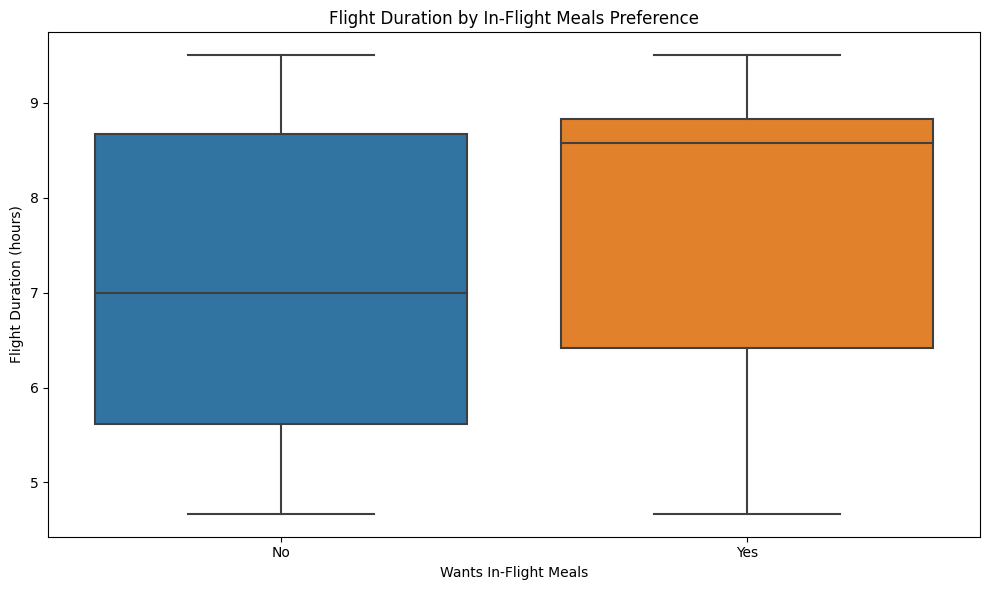

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='wants_in_flight_meals', y='flight_duration')
plt.xlabel('Wants In-Flight Meals')
plt.ylabel('Flight Duration (hours)')
plt.title('Flight Duration by In-Flight Meals Preference')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

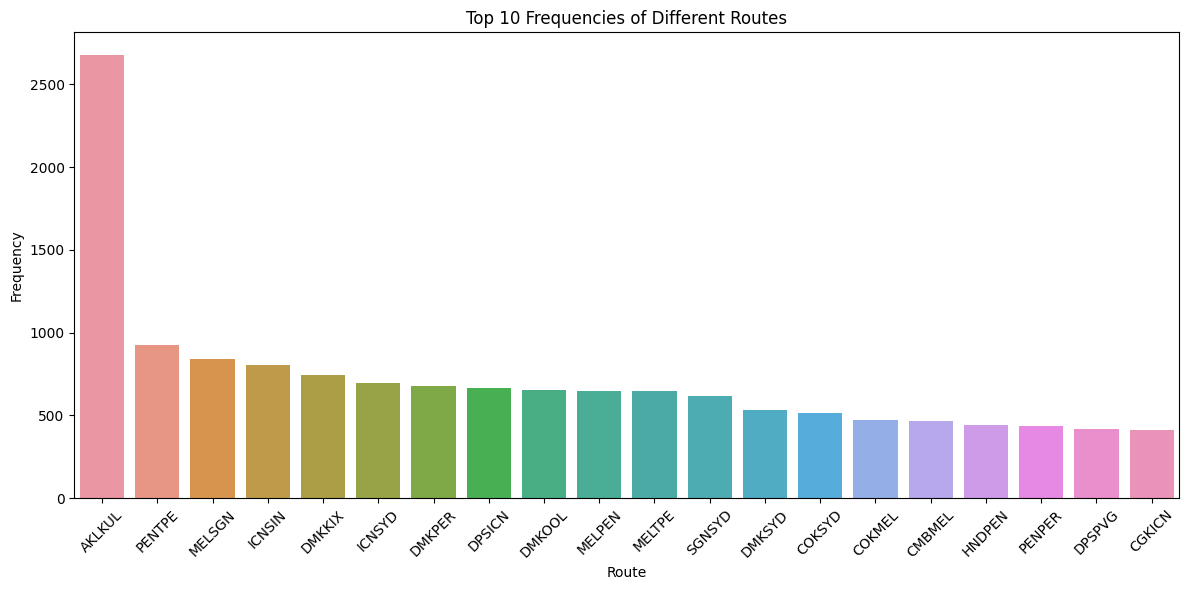

In [20]:
plt.figure(figsize=(12, 6))
route_counts = df['route'].value_counts().sort_values(ascending=False).head(20)
sns.barplot(x=route_counts.index, y=route_counts.values)
plt.xlabel('Route')
plt.ylabel('Frequency')
plt.title('Top 10 Frequencies of Different Routes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


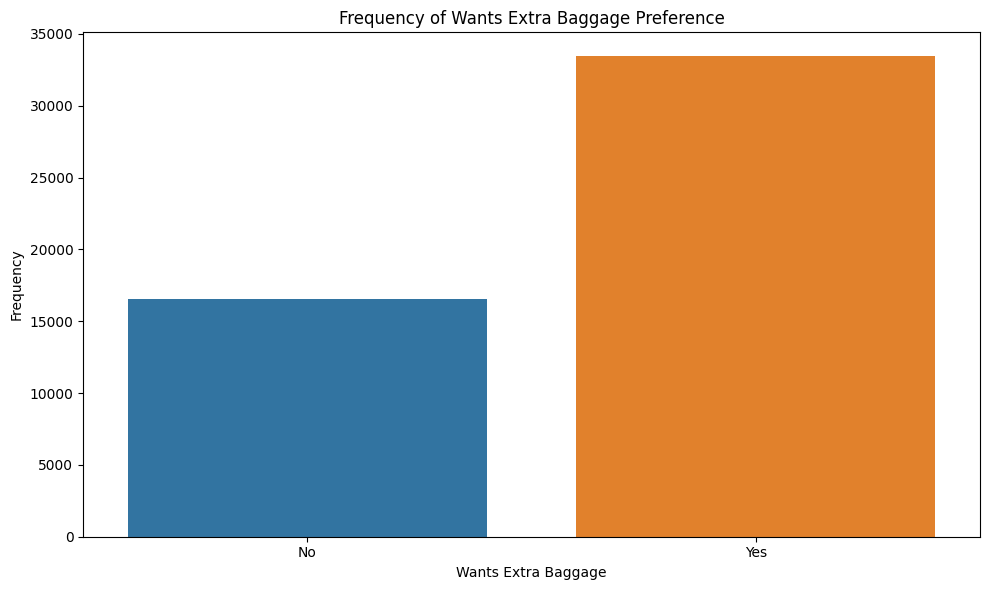

In [21]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each preference
extra_baggage_counts = df['wants_extra_baggage'].value_counts()

# Create a bar plot
sns.barplot(x=extra_baggage_counts.index, y=extra_baggage_counts.values)

plt.xlabel('Wants Extra Baggage')
plt.ylabel('Frequency')
plt.title('Frequency of Wants Extra Baggage Preference')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

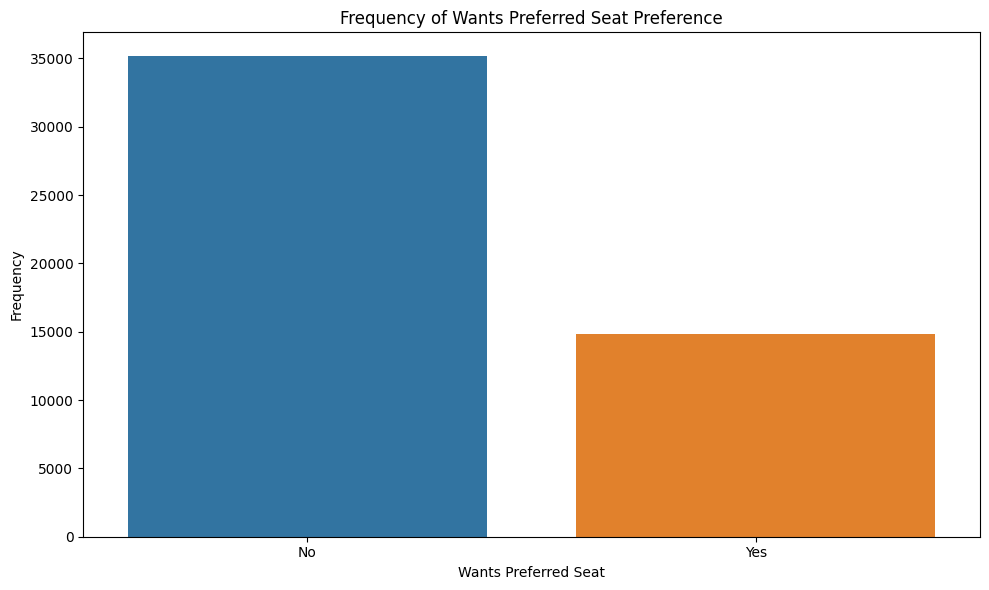

In [22]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each preference
preferred_seat_counts = df['wants_preferred_seat'].value_counts()

# Create a bar plot
sns.barplot(x=preferred_seat_counts.index, y=preferred_seat_counts.values)

plt.xlabel('Wants Preferred Seat')
plt.ylabel('Frequency')
plt.title('Frequency of Wants Preferred Seat Preference')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

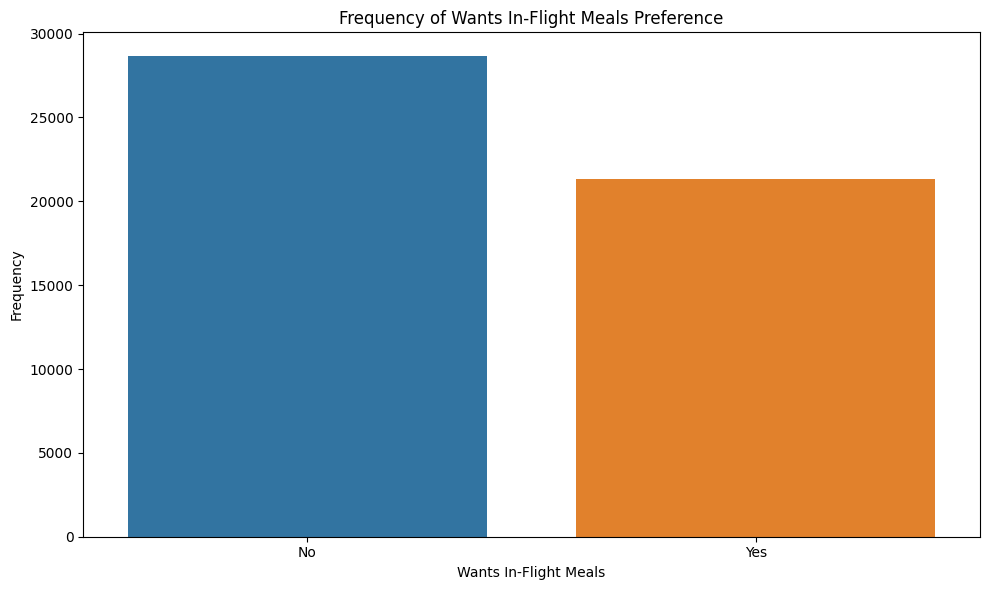

In [23]:
plt.figure(figsize=(10, 6))

# Count the occurrences of each preference
in_flight_meals_counts = df['wants_in_flight_meals'].value_counts()

# Create a bar plot
sns.barplot(x=in_flight_meals_counts.index, y=in_flight_meals_counts.values)

plt.xlabel('Wants In-Flight Meals')
plt.ylabel('Frequency')
plt.title('Frequency of Wants In-Flight Meals Preference')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

In [24]:
df['route'].nunique()

799

In [25]:
route_counts = df['route'].value_counts()
print(route_counts)

AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64


In [26]:
# Set the threshold for routes to be considered as "rare"
rare_threshold = 50  # You can adjust this value

# Identify routes that are rare based on the threshold
rare_routes = route_counts[route_counts < rare_threshold].index

# Replace rare routes with 'Other' in the 'route' column
df['route'] = df['route'].apply(lambda route: 'Other' if route in rare_routes else route)

In [27]:
route_counts = df['route'].value_counts()
print(route_counts)

Other     8422
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
          ... 
DADOOL      53
RGNSYD      51
CNXTPE      50
JOGKIX      50
BKICTS      50
Name: route, Length: 217, dtype: int64


In [28]:
df['booking_origin'].nunique()

104

In [29]:
bo_counts = df['booking_origin'].value_counts()
print(bo_counts)

Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64


In [30]:
# Set the threshold for booking origins to be considered as "rare"
rare_threshold = 100

# Calculate the counts of each booking origin
booking_origin_counts = df['booking_origin'].value_counts()

# Identify booking origins that are rare based on the threshold
rare_booking_origins = booking_origin_counts[booking_origin_counts < rare_threshold].index

# Replace rare booking origins with 'Other' in the 'booking_origin' column
df['booking_origin'] = df['booking_origin'].apply(lambda origin: 'Other' if origin in rare_booking_origins else origin)

In [31]:
bo_counts = df['booking_origin'].value_counts()
print(bo_counts)

Australia         17872
Malaysia           7174
South Korea        4559
Japan              3885
China              3387
Indonesia          2369
Taiwan             2077
Thailand           2030
India              1270
Other              1078
New Zealand        1074
Singapore          1044
United States       456
Vietnam             388
Macau               304
Hong Kong           295
Philippines         266
United Kingdom      173
Brunei              167
Cambodia            132
Name: booking_origin, dtype: int64


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

In [33]:
cat_cols=df.select_dtypes(include = 'object').columns
df = pd.get_dummies(df, columns=cat_cols)

## Part2

In [34]:
# Select features and target
X = df.drop(['booking_complete'], axis=1) 
y = df['booking_complete']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Removing outliers using Z-score
z_scores = zscore(X_train)
mask = (z_scores < 3).all(axis=1)
X_train = X_train[mask]
y_train = y_train[mask]

In [36]:
# Initialize SMOTE with the desired sampling strategy
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to balance the training data
X_train, y_train = smote.fit_resample(X_train, y_train)


In [37]:
# Feature selection
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Build Model

In [38]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.85


In [39]:
# Creating and training the RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy')
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [40]:
# Evaluating the model
accuracy= rfc.score(X_test, y_test)
print("Test accuracy :", accuracy)

Test accuracy : 0.8517


In [41]:
# Cross-validation
cv_results = cross_validate(rfc, X_new, y, cv=10, scoring=["accuracy", "precision", "recall"])
print("Accuracy from cross-validation:", cv_results["test_accuracy"].mean())

Accuracy from cross-validation: 0.83008


In [42]:
# Grid Search for hyperparameter tuning
criterion = ['gini', 'entropy']
n_estimators = [100, 200, 300]
max_features = ['sqrt']
max_depth = [10, 20, None]

params = {'criterion': criterion,
          'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth}

gs = GridSearchCV(rfc, param_grid=params, n_jobs=2)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy'), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, None], 'max_features': ['sqrt'],
                         'n_estimators': [100, 200, 300]})

In [43]:
best_params = gs.best_params_
print("Best parameters:", best_params)

best_score = gs.best_score_
print("Best score:", best_score)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best score: 0.85


## Evaluate

In [44]:
# Final evaluation using best parameters
best_rfc = gs.best_estimator_
final_accuracy = best_rfc.score(X_test, y_test)
print("Final accuracy with best parameters:", final_accuracy)

Final accuracy with best parameters: 0.852


In [45]:
# Classification report
y_pred = best_rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8520
           1       0.50      0.01      0.02      1480

    accuracy                           0.85     10000
   macro avg       0.68      0.50      0.47     10000
weighted avg       0.80      0.85      0.79     10000



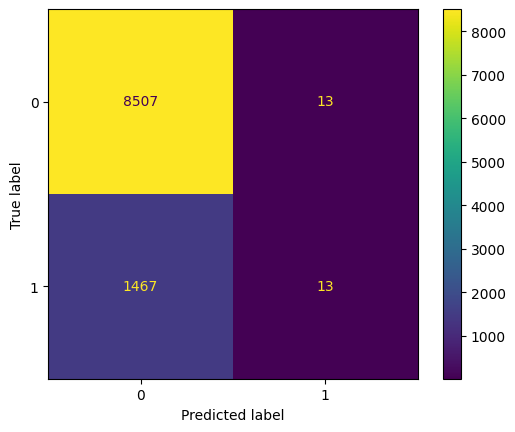

In [46]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rfc,X_test,y_test);

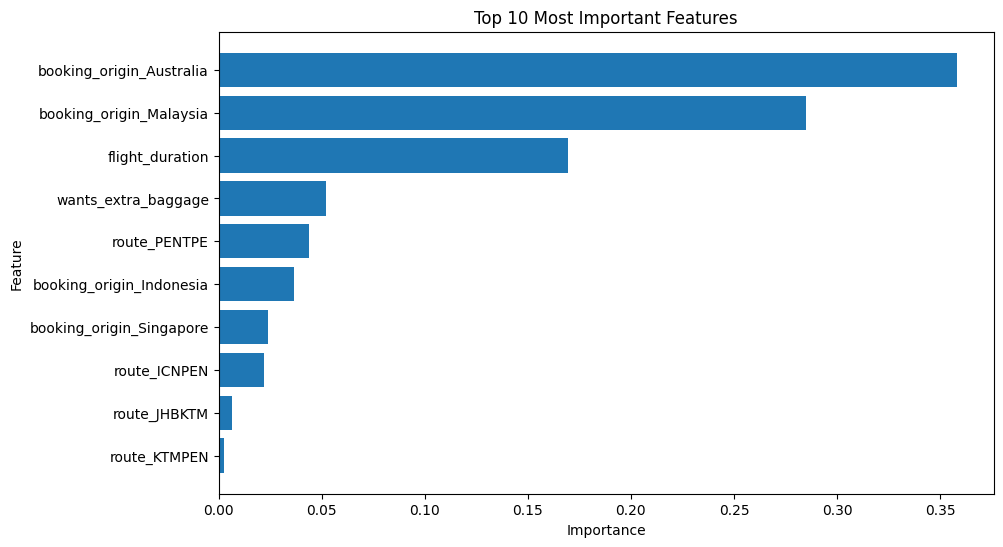

In [47]:
# Get feature importances from the trained model
feature_importances = best_rfc.feature_importances_

# Get the column names of the selected features
selected_feature_names = X.columns[selector.get_support(indices=True)]

# Create a DataFrame with feature importances and names
feature_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 10 features
top_features = feature_importance_df.head(10)

# Plotting the 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [48]:
top_features

,Feature,Importance
6,booking_origin_Australia,0.358087
8,booking_origin_Malaysia,0.285086
1,flight_duration,0.169670
0,wants_extra_baggage,0.052309
5,route_PENTPE,0.043762
7,booking_origin_Indonesia,0.036408
9,booking_origin_Singapore,0.023978
2,route_ICNPEN,0.021802
3,route_JHBKTM,0.006310
4,route_KTMPEN,0.002588
